<a href="https://colab.research.google.com/github/priya456-hash/Thesis/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required libraries

import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile 
import heapq
import matplotlib.image as mpimg
import tensorflow as tf 
from scipy.stats import pearsonr
from tensorflow.keras import layers 
from tensorflow.keras import models 
from tensorflow.keras import Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)



In [ ]:
# Loading tensorflow 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
CFG = dict(
        batch_size        =  16,     # 8; 16; 32; 64; bigger batch size leads to memory allocation issues. 
        epochs            =  100,   # 5; 10; 20;
        verbose           =   1,    # 0; 1
        workers           =   3,    # 1; 2; 3

        optimizer         = 'SGD', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;    
)



In [ ]:
# Unzip all files to same directory of zip file
zip_file = '/content/Bone_parts.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Create a test, train and validation directories
dir = '/content/Bone_parts'
train_dir = os.path.join(dir, 'train')
validation_dir = os.path.join(dir, 'validation')
test_dir = os.path.join(dir, 'test')

# Biomaterial Directories
train_Biomaterial_dir = os.path.join(train_dir, 'biomaterial')
test_Biomaterial_dir = os.path.join(test_dir, 'biomaterial')

# bone_marrow Directories
train_bone_marrow_dir = os.path.join(train_dir, 'bone_marrow')
test_bone_marrow_dir = os.path.join(test_dir, 'bone_marrow')

#bone_with_osteocytes directories
train_bone_with_osteocytes_dir = os.path.join(train_dir, 'bone_with_osteocytes')
test_bone_with_osteocytes_dir = os.path.join(test_dir, 'bone_with_osteocytes')

#bone_without_osteocytes
train_bone_without_osteocytes_dir = os.path.join(train_dir, 'bone_without_osteocytes')
test_bone_without_osteocytes_dir = os.path.join(test_dir, 'bone_without_osteocytes')


# tissue_fibrous
train_tissue_fibrous_dir = os.path.join(train_dir, 'tissue_fibrous')
test_tissue_fibrous_dir = os.path.join(test_dir, 'tissue_fibrous')

print(train_tissue_fibrous_dir)


/content/Bone_parts/train/tissue_fibrous


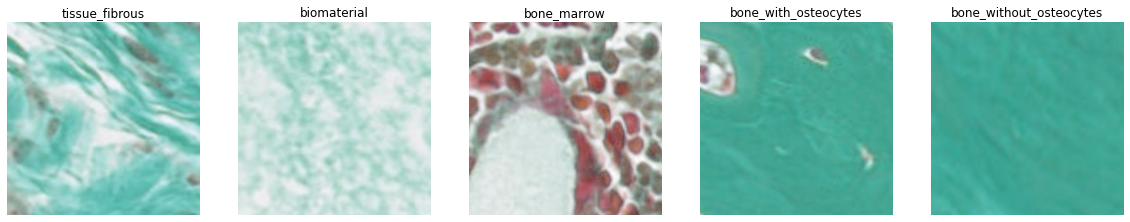

In [ ]:
# Plot a sample image

#create list for all images
images = []
names = []

#Get first image of tissue_fibrous
train_tissue_fibrous_filenames = os.listdir(train_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(train_tissue_fibrous_dir + "/" + train_tissue_fibrous_filenames[0]))
names.append("tissue_fibrous")

#Get first image of biomaterial
train_Biomaterial_filenames = os.listdir(train_Biomaterial_dir)

#Plot the first image
images.append(mpimg.imread(train_Biomaterial_dir + "/" + train_Biomaterial_filenames[0]))
names.append("biomaterial")

#Get first image of bone marrow
train_bone_marrow_filenames = os.listdir(train_bone_marrow_dir)

#Plot the first image
images.append(mpimg.imread(train_bone_marrow_dir + "/" + train_bone_marrow_filenames[0]))
names.append("bone_marrow")

#Get first image of bone with osteocytes 
train_bone_with_osteocytes_filenames = os.listdir(train_bone_with_osteocytes_dir)

#Plot the first image
images.append(mpimg.imread(train_bone_with_osteocytes_dir + "/" + train_bone_with_osteocytes_filenames[0]))
names.append("bone_with_osteocytes")

#Get first image of tissue_fibrous
train_bone_without_osteocytes_filenames = os.listdir(train_bone_without_osteocytes_dir)
names.append("bone_without_osteocytes")

#Plot the first image
images.append(mpimg.imread(train_bone_without_osteocytes_dir + "/" + train_bone_without_osteocytes_filenames[0]))

nrows = 1
ncols = 5
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
for i in range(5):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(images[i])
  plt.title(names[i])
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/

# Data Augmentation 

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.4,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',
                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.4)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test


# Train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical'
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                               
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory(test_dir,
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical',shuffle=False    
)

Found 150 images belonging to 5 classes.
Found 96 images belonging to 5 classes.
Found 209 images belonging to 5 classes.


In [ ]:
# Class weights for assigning different weights to the classes. 
# calculate the class weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes), 
                                                  train_generator.classes) 

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict   = { unique_class_weights[i]: w for i,w in enumerate(class_weights) }

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [0.9375     1.2        1.03448276 0.9375     0.9375    ]

[0 1 2 3 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
[0 1 2 3 4]
dict_keys([0, 1, 2, 3, 4])
dict_values([32, 25, 29, 32, 32])


In [ ]:
model_VGG19 = tf.keras.Sequential([
     tf.keras.applications.VGG19(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    
    GlobalAveragePooling2D(),
    

    
    #Dense(256, activation='relu'), 
    #Dropout(0.3), 
    #BatchNormalization(),
    
    #Dense(64, activation='relu'), 
    #Dropout(0.2), 
    #BatchNormalization(),
    
    Dense(5, activation='softmax') 
    
])
    
model_VGG19.compile(
    optimizer = CFG['optimizer'],
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
    #loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# We reduce significantly number of trainable parameters by freezing certain layers, excluding from training, i.e. their weights will never be updated

# freeze the first 1 layer

model_VGG19.layers[0].trainable = False
#for layer in model_VGG16.layers[:1]:
#    layer.trainable = False
model_VGG19.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 2,565
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#REFERENCES: tf.function-decorated function tried to create variables on non-first call'. 
tf.config.run_functions_eagerly(True) # otherwise error, useful for debugging.

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
#Callback to save the Keras model or model weights at some frequency
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(#filepath=path_model,
                                   #filepath=CFG['path_model']+'VGG19.hdf5'
                                   filepath = CFG['path_model']+'VGG19-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history = model_VGG19.fit(train_generator, 
                             epochs=CFG['epochs'], 
                             workers=CFG['workers'],
                             steps_per_epoch = train_generator.n // 2, 
                             validation_data=valid_generator, 
                             shuffle=False,
                             validation_steps=valid_generator.n // 2, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/100
75/75 [==============================] - 64s 854ms/step - loss: 0.3450 - accuracy: 0.5867 - val_loss: 0.1376 - val_accuracy: 0.9792

Epoch 00001: val_loss improved from inf to 0.13765, saving model to ../working/VGG19-01-0.14.hdf5
Epoch 2/100
75/75 [==============================] - 64s 849ms/step - loss: 0.3019 - accuracy: 0.7133 - val_loss: 0.3563 - val_accuracy: 0.5417

Epoch 00002: val_loss did not improve from 0.13765
Epoch 3/100
75/75 [==============================] - 64s 848ms/step - loss: 0.1213 - accuracy: 0.9124 - val_loss: 0.0388 - val_accuracy: 0.9688

Epoch 00003: val_loss improved from 0.13765 to 0.03877, saving model to ../working/VGG19-03-0.04.hdf5
Epoch 4/100
75/75 [==============================] - 64s 850ms/step - loss: 0.0233 - accuracy: 0.9858 - val_loss: 0.0138 - val_accuracy: 0.9896

Epoch 00004: val_loss improved from 0.03877 to 0.01377, saving model to ../working/VGG19-04-0.01.hdf5
Epoch 5/100
75/75 [==============================] - 64s 850ms/step

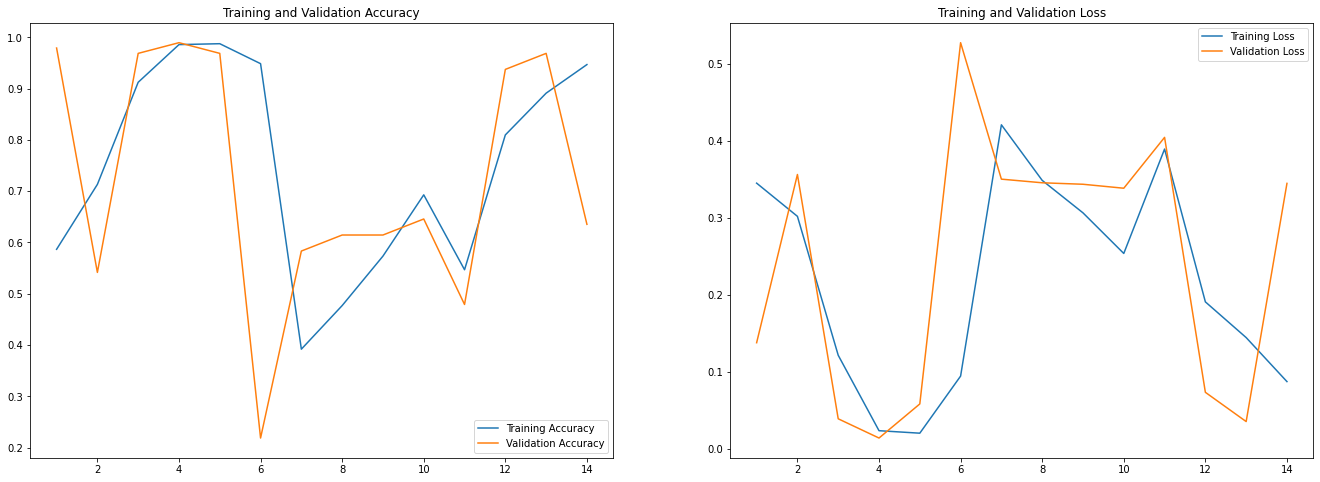

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print("Evaluate on test data")
results = model_VGG19.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
209/209 [==============================] - 10s 48ms/step - loss: 0.3071 - accuracy: 0.7177
test loss, test acc: [0.3070954978466034, 0.7177033424377441]


In [ ]:
print("Evaluate on test data")
results = model_VGG19.evaluate(test_generator)
print("test loss, test acc:", results)



Evaluate on test data
209/209 [==============================] - 10s 48ms/step - loss: 0.3071 - accuracy: 0.7177
test loss, test acc: [0.3070954978466034, 0.7177033424377441]
